# Three Lasers

Consider that the refractive index of the growing layer follows a simple Cauchy law $n(\lambda) = A + B/\lambda^2$. Then, to determine $A$, $B$ and the growth velocity of a layer, we need the measurements of at least three laser wavelengths, better yet a whole spectrum (white laser + spectrometer).

## Imports

In [1]:
# numerics
import jax.numpy as jnp
import numpy as np
import jax
jax.config.update("jax_enable_x64", True)
import optimistix as optx

# plotting
import matplotlib.pyplot as plt

# our library
from reflax import polanalyze, variable_layer_thickness_simulation
from reflax.parameter_classes.parameters import OpticsParams, SetupParams, LayerParams, GrowthModel
from reflax.forward_model.variable_layer_size import power_forward_model
from reflax.data_analysis import cws
from reflax.parameter_classes.parameters import SetupParams
from reflax.forward_model.variable_layer_size import forward_model

## General Setup

In [2]:
polar_angle = jnp.deg2rad(25)
azimuthal_angle = jnp.deg2rad(0)

setup_params = SetupParams(
    polar_angle = polar_angle,
    azimuthal_angle = azimuthal_angle
)

polarization_state = "Linear TE/perpendicular/s"
transverse_electric_component, transverse_magnetic_component = polanalyze(polarization_state)

Generally assume

In [3]:
permeability_reflection = 1
permittivity_reflection = 1

permeability_transmission = 1
permittivity_transmission = (3.8827 + 0.019626j)**2

optics_params = OpticsParams(
    permeability_reflection = permeability_reflection,
    permittivity_reflection = permittivity_reflection,
    permeability_transmission = permeability_transmission,
    permittivity_transmission = permittivity_transmission,
    transverse_electric_component = transverse_electric_component,
    transverse_magnetic_component = transverse_magnetic_component
)

backside_mode = 1

Assume a static layer

In [4]:
static_layer_thicknesses = jnp.array([5.0])
permeability_static_size_layers = jnp.array([1.0])
permittivity_static_size_layers = jnp.array([1.45704**2])

static_layer_params = LayerParams(
    permeabilities = permeability_static_size_layers,
    permittivities = permittivity_static_size_layers,
    thicknesses = static_layer_thicknesses
)

For the variable layer let us write a function to get the permability of the layer at a given wavelength

In [5]:
def get_permittivity(wavelength, A, B):
    refractive_index = A + B / (wavelength**2)
    # assume a permability of 1
    return refractive_index**2

And initialize the layer parameters

In [6]:
variable_layer_params = LayerParams(
    permeabilities = 1.0,
)

## Simulated Signals from Three Lasers

Consider our three lasers have wavelengths

In [7]:
wavelengths = jnp.array([400, 420, 440], dtype=jnp.float64)

Now we specify the parameters we later want to recover. For $A$ and $B$ we choose

In [8]:
# Borosilicate glass BK7: A = 1.5046, B = 0.00420 um^2 = 4200 nm^2
A_ref = 1.5046
B_ref = 4200

And we choose a constant growth velocity of

In [9]:
layer_growth_velocity_ref = 0.1

leading to thicknesses of

In [10]:
final_time = 7049
time_points = jnp.arange(0, final_time)
variable_layer_thicknessses = layer_growth_velocity_ref * time_points

Now we can define our forward model

In [11]:
def multi_wavelength_forward_model(A, B, growth_velocity):
    return jax.vmap(lambda wavelength:
        forward_model(
            model = 0,
            setup_params = setup_params._replace(wavelength = wavelength),
            optics_params = optics_params,
            static_layer_params = static_layer_params,
            variable_layer_params = variable_layer_params._replace(permittivities = get_permittivity(wavelength, A, B)),
            variable_layer_thicknesses = growth_velocity * time_points,
            backside_mode = backside_mode,
            normalization = 1
        )
    )(wavelengths)

def single_wavelength_forward_model(refractive_index, growth_velocity):
    return forward_model(
        model = 0,
        setup_params = setup_params._replace(wavelength = 500),
        optics_params = optics_params,
        static_layer_params = static_layer_params,
        variable_layer_params = variable_layer_params._replace(permittivities = refractive_index**2),
        variable_layer_thicknesses = growth_velocity * time_points,
        backside_mode = backside_mode,
        normalization = 0
    )

Lets do an intermezzo check on the loss degeneracy with only one laser.

In [ ]:
refraction_index1 = 1.5
growth_velocity1 = 0.1

normalized = True

if normalized:
    zscore = lambda x: (x - jnp.mean(x)) / jnp.std(x)
else:
    zscore = lambda x: x

reference_reflectivity1 = zscore(single_wavelength_forward_model(refraction_index1, growth_velocity1))

# add noise to the reference reflectivity
reference_reflectivity1 += jax.random.normal(jax.random.PRNGKey(0), reference_reflectivity1.shape) * 0.01

# does not work
# def fourier_mean_distance(signal1, signal2):
#     # compute the fourier transform of the signals
#     fourier_transform1 = jnp.fft.fft(signal1)
#     fourier_transform2 = jnp.fft.fft(signal2)
#     # calculate power spectral density
#     psd1 = jnp.abs(fourier_transform1)**2
#     psd2 = jnp.abs(fourier_transform2)**2
#     # calculate the distance between the mean frequencies
#     frequencies = jnp.fft.fftfreq(len(signal1))
#     mean_frequency1 = jnp.sum(frequencies * psd1) / jnp.sum(psd1)
#     mean_frequency2 = jnp.sum(frequencies * psd2) / jnp.sum(psd2)
#     return jnp.abs(mean_frequency1 - mean_frequency2)

# from jax.scipy.signal import find_peaks

# def peak_distance(signal1, signal2):
#     peaks, _ = find_peaks(signal1, distance = 100, prominence=0.1)
#     trophs, _ = find_peaks(-signal1, distance = 100, prominence=0.1)
#     local_extrema1 = jnp.sort(jnp.concatenate([peaks, trophs]))

#     peaks, _ = find_peaks(signal2, distance = 100, prominence=0.1)
#     trophs, _ = find_peaks(-signal2, distance = 100, prominence=0.1)
#     local_extrema2 = jnp.sort(jnp.concatenate([peaks, trophs]))

#     # get mean distance between the local extrema
#     return jnp.abs(jnp.mean(jnp.diff(local_extrema1)) - jnp.mean(jnp.diff(local_extrema2)))

def residuals1(params):
    refractive_index_it, growth_velocity_it = params
    reflectivity_it = zscore(single_wavelength_forward_model(refractive_index_it, growth_velocity_it))
    return jnp.mean((reflectivity_it - reference_reflectivity1)**2)

refractive_index_min = 1.3
refractive_index_max = 1.8

growth_velocity_min = 0.05
growth_velocity_max = 0.175

refractive_indices = jnp.linspace(refractive_index_min, refractive_index_max, 100)
growth_velocities = jnp.linspace(growth_velocity_min, growth_velocity_max, 100)

refractive_indices, growth_velocities = jnp.meshgrid(refractive_indices, growth_velocities)

refractive_indices = refractive_indices.flatten()
growth_velocities = growth_velocities.flatten()

residuals_values = jax.lax.map(residuals1, (refractive_indices, growth_velocities), batch_size=1000)

# plot the residuals as a scatter plot with color coding and color bar using a logarithmic color scale
plt.scatter(refractive_indices, growth_velocities, c=jnp.log10(residuals_values), cmap="viridis")
plt.colorbar(label="log10(Residuals)")
plt.xlabel("Refractive index")
plt.ylabel("Growth velocity")
plt.title("log-residuals (single wavelength, {})".format("normalized" if normalized else "not normalized"))

# plot the solution as a red dot
plt.plot(refraction_index1, growth_velocity1, "ro")

# theoretically equivalent solutions
def velocity_from_refractive_index(refractive_index):
    variable_layer_permittivity_A = refraction_index1 ** 2
    variable_layer_permittivity_B = refractive_index ** 2

    def delta_var(variable_layer_permittivity):
        n0 = jnp.sqrt(optics_params.permeability_reflection * optics_params.permittivity_reflection)
        n1 = jnp.sqrt(variable_layer_params.permeabilities * variable_layer_permittivity)
        return jnp.sqrt(n1 ** 2 - n0 ** 2 * jnp.sin(setup_params.polar_angle) ** 2)

    return growth_velocity1 * delta_var(variable_layer_permittivity_A) / delta_var(variable_layer_permittivity_B)

neval = jnp.linspace(refractive_index_min, refractive_index_max, 100)
growth_velocities_degenerate = velocity_from_refractive_index(neval)

plt.scatter(neval, growth_velocities_degenerate, label="theoretically equivalent solutions", c="black", s=1, alpha=0.5)

import optax
def gradient_descent_optimization(func, x_init, learning_rate=20, tol=0.5, max_iter=2000):
    xlist = []
    x = x_init
    loss_list = []
    xlist.append(x)

    optimizer = optax.adam(learning_rate=learning_rate)
    optimizer_state = optimizer.init(x)

    for _ in range(max_iter):
        # Compute the function value and its gradient
        loss, f_grad = jax.value_and_grad(func)(x)
        loss_list.append(loss)
        
        # Update the parameter
        updates, optimizer_state = optimizer.update(f_grad, optimizer_state)
        x = optax.apply_updates(x, updates)
        xlist.append(x)
        
        # Check convergence
        if jnp.linalg.norm(updates) < tol:
            break

    xlist = jnp.array(xlist)
    
    return x, xlist, loss_list

x_init = jnp.array([1.35, 0.13])

optimal_params, xlist, loss_list = gradient_descent_optimization(residuals1, x_init, learning_rate=1e-2, tol=1e-10, max_iter=400)

plt.plot(xlist[:, 0], xlist[:, 1], "-", label="Gradient descent", color = "orange", linewidth=2)

plt.legend()

TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on traced array with shape float64[7049]
This BatchTracer with object id 130115950094400 was created on line:
  /tmp/ipykernel_2868572/3279670941.py:7 (<lambda>)
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError

And retrieve the reference reflectivities

In [13]:
reference_reflectivities = multi_wavelength_forward_model(A_ref, B_ref, layer_growth_velocity_ref)

# add noise to the reference reflectivities
noise_level = 0.01
reference_reflectivities += noise_level * jax.random.normal(jax.random.PRNGKey(4242), reference_reflectivities.shape)

and plot them

Text(0, 0.5, 'Reflectivity in %')

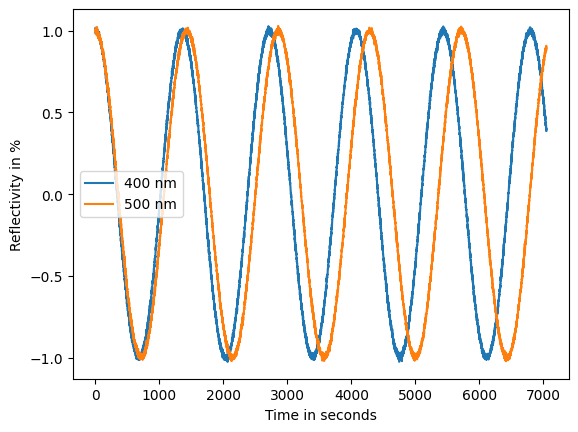

In [14]:
plt.plot(time_points, reference_reflectivities[0], label = "400 nm")
plt.plot(time_points, reference_reflectivities[1], label = "500 nm")
# plt.plot(time_points, reference_reflectivities[2], label = "600 nm")

plt.legend()
plt.xlabel("Time in seconds")
plt.ylabel("Reflectivity in %")

## Recovery of Parameters

Problem: There are many convex basins, frequency optimization is not straightforward.

Solutions:

CASE A: multiple periods
In case we have multiple periods, we can directly regress on a frequency expression, to find
the parameters relevant therein. Or we might add a term to the loss giving the distance between the 
maxima of the power spectra (so a frequency difference), but in a way that this is a differentiable measure, so maybe rather the mean frequency.

ALTERNATIVE
First perform a kind of grid search.

Alternative: Initial parameter grid search

In [15]:
def residuals(params):
    A_it, B_it, growth_velocity_it = params
    reflectivities = multi_wavelength_forward_model(A_it, B_it, growth_velocity_it)
    return jnp.sum((reference_reflectivities - reflectivities) ** 2)

A_guess_min = 1.1
A_guess_max = 1.9

B_guess_min = 1000
B_guess_max = 5000

growth_velocity_guess_min = 0.01
growth_velocity_guess_max = 1

num_points_per_dimension = 100

A_guesses = jnp.linspace(A_guess_min, A_guess_max, num_points_per_dimension)
B_guesses = jnp.linspace(B_guess_min, B_guess_max, num_points_per_dimension)
growth_velocity_guesses = jnp.linspace(growth_velocity_guess_min, growth_velocity_guess_max, num_points_per_dimension)

A_guesses, B_guesses, growth_velocity_guesses = jnp.meshgrid(A_guesses, B_guesses, growth_velocity_guesses)

residuals_values = jax.lax.map(residuals, (A_guesses.flatten(), B_guesses.flatten(), growth_velocity_guesses.flatten()), batch_size=1000)

print(residuals_values.shape)

min_index = jnp.argmin(residuals_values)
A_guess = A_guesses.flatten()[min_index]
B_guess = B_guesses.flatten()[min_index]
growth_velocity_guess = growth_velocity_guesses.flatten()[min_index]

print(f"Best guess for A: {A_guess}")
print(f"Best guess for B: {B_guess}")
print(f"Best guess for growth velocity: {growth_velocity_guess}")

(1000000,)
Best guess for A: 1.504040404040404
Best guess for B: 4313.131313131314
Best guess for growth velocity: 0.1


Let us choose initial guesses for the parameters

In [16]:
# A_guess = 1.51
# B_guess = 4190
# growth_velocity_guess = 0.11

initial_guess_norm = jnp.array([A_guess, B_guess, growth_velocity_guess])

print(initial_guess_norm)

[1.50404040e+00 4.31313131e+03 1.00000000e-01]


and plot this

Text(0, 0.5, 'Reflectivity in %')

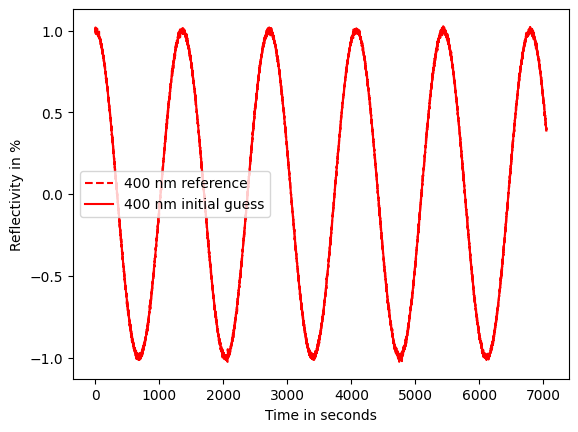

In [17]:
initial_guess_reflectivities = multi_wavelength_forward_model(A_guess, B_guess, growth_velocity_guess)

plt.plot(time_points, reference_reflectivities[0], label = "400 nm reference", color = "red", linestyle = "--")
# plt.plot(time_points, reference_reflectivities[1], label = "500 nm reference", color = "green", linestyle = "--")
# plt.plot(time_points, reference_reflectivities[2], label = "600 nm reference", color = "blue", linestyle = "--")

plt.plot(time_points, initial_guess_reflectivities[0], label = "400 nm initial guess", color = "red")
# plt.plot(time_points, initial_guess_reflectivities[1], label = "500 nm initial guess", color = "green")
# plt.plot(time_points, initial_guess_reflectivities[2], label = "600 nm initial guess", color = "blue")

plt.legend()
plt.xlabel("Time in seconds")
plt.ylabel("Reflectivity in %")

and set up the residual function

In [18]:
def residuals(params, consts):
    A_it, B_it, growth_velocity_it = params * initial_guess_norm
    reflectivities = multi_wavelength_forward_model(A_it, B_it, growth_velocity_it)
    return reference_reflectivities - reflectivities

Lets solve this, drill baby drill

In [19]:
initial_guess = jnp.array([1.0, 1.0, 1.0])

solver = optx.LevenbergMarquardt(
    rtol=1e-8, atol=1e-8
)

# import optax

# solver = optx.OptaxMinimiser(
#     optax.adam(1e-4),
#     rtol = 1e-10,
#     atol = 1e-10
# )

sol = optx.least_squares(residuals, solver, initial_guess).value

E0122 14:48:47.095320 2868572 pjrt_stream_executor_client.cc:3085] Execution of replica 0 failed: INTERNAL: jaxlib/gpu/solver_handle_pool.cc:37: operation gpusolverDnCreate(&handle) failed: cuSolver internal error


XlaRuntimeError: INTERNAL: jaxlib/gpu/solver_handle_pool.cc:37: operation gpusolverDnCreate(&handle) failed: cuSolver internal error

In [688]:
A_sol, B_sol, growth_velocity_sol = sol * initial_guess_norm

print(f"Found A = {A_sol}, B = {B_sol}, growth velocity = {growth_velocity_sol}")
print(f"with residuals {jnp.sum(jnp.abs(residuals(sol, None)))}")
print(f"True  A = {A_ref}, B = {B_ref}, growth velocity = {layer_growth_velocity_ref}")

Found A = 1.5063630419976384, B = 4194.640141340725, growth velocity = 0.09987698572310502
with residuals 337.790278870173
True  A = 1.5046, B = 4200, growth velocity = 0.1


Also plot the results

Text(0, 0.5, 'Reflectivity in %')

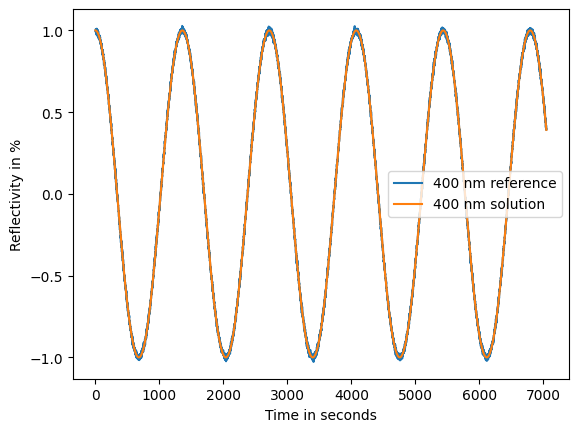

In [689]:
solution_reflectivities = multi_wavelength_forward_model(A_sol, B_sol, growth_velocity_sol)

plt.plot(time_points, reference_reflectivities[0], label = "400 nm reference")
# plt.plot(time_points, reference_reflectivities[1], label = "500 nm reference")
# plt.plot(time_points, reference_reflectivities[2], label = "600 nm reference")

plt.plot(time_points, solution_reflectivities[0], label = "400 nm solution")
# plt.plot(time_points, solution_reflectivities[1], label = "500 nm solution")
# plt.plot(time_points, solution_reflectivities[2], label = "600 nm solution")

plt.legend()
plt.xlabel("Time in seconds")
plt.ylabel("Reflectivity in %")